# Bulk RNA-seq analysis
This notebook generates major results in Figures 2, and S2

In [6]:
#load package
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(factoextra)
    library(ggforce)
    library(pheatmap)
    library(fgsea)
    library(DESeq2)
    library(enrichplot)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(msigdbr)
    library(ggplot2)
    library(dplyr)
}))

In [8]:
# Fig size setting
fig_size <- function (height, width) {
    options(repr.plot.height = height, 
            repr.plot.width = width)
}

In [2]:
#load raw counts 
data <- read.csv("/Users/yujiaoh/Princeton Dropbox/Yujiao Han/0-My Dropbox/Manuscript/Yujiao_Manuscript_v4/dataflie/rowcount_niche_macrophage_geneonrow.csv", header = T, row.names = "gene_name")
data <- data[,sort(colnames(data))]
colSums(data)

CD11b.F4.80..BoMet_1  CD11b.F4.80..BoMet_2  CD11b.F4.80..BoMet_3 
             30332442              24278074              25603945 
CD11b.F4.80..Normal_1 CD11b.F4.80..Normal_2 CD11b.F4.80..Normal_3 
             15041967              18500621              20777176 
      Triple..BoMet_1       Triple..BoMet_2       Triple..BoMet_3 
             18565114              20952846              21579543 
     Triple..Normal_1      Triple..Normal_2      Triple..Normal_3 
             13687957              20187500              20492640

In [10]:
# assign replicates to each condition to construct colData
condition <- c(rep("CD11b+D480+_Macrophage_BoMet", 3), 
               rep("CD11b+D480+_Macrophage_Normal", 3), 
               rep("CD163b+VCAM1+CCR3+_Macrophage_BoMet", 3), 
               rep("CD163b+VCAM1+CCR3+_Macrophage_Normal", 3))
my_colData <- as.data.frame(condition)
rownames(my_colData) <- colnames(data)
my_colData

,condition
,<chr>
CD11b.F4.80..BoMet_1,CD11b+D480+_Macrophage_BoMet
CD11b.F4.80..BoMet_2,CD11b+D480+_Macrophage_BoMet
CD11b.F4.80..BoMet_3,CD11b+D480+_Macrophage_BoMet
CD11b.F4.80..Normal_1,CD11b+D480+_Macrophage_Normal
CD11b.F4.80..Normal_2,CD11b+D480+_Macrophage_Normal
CD11b.F4.80..Normal_3,CD11b+D480+_Macrophage_Normal
Triple..BoMet_1,CD163b+VCAM1+CCR3+_Macrophage_BoMet
Triple..BoMet_2,CD163b+VCAM1+CCR3+_Macrophage_BoMet
Triple..BoMet_3,CD163b+VCAM1+CCR3+_Macrophage_BoMet


In [11]:
#create a DESeq2 object
suppressMessages({
    dds <- DESeqDataSetFromMatrix(countData = round(data),
                              colData = my_colData,
                              design = ~condition)
    dds <- DESeq(dds)
    dds
    head(dds@assays@data$counts)
    })

,CD11b.F4.80..BoMet_1,CD11b.F4.80..BoMet_2,CD11b.F4.80..BoMet_3,CD11b.F4.80..Normal_1,CD11b.F4.80..Normal_2,CD11b.F4.80..Normal_3,Triple..BoMet_1,Triple..BoMet_2,Triple..BoMet_3,Triple..Normal_1,Triple..Normal_2,Triple..Normal_3
0610005C13Rik,18,111,0,2,0,0,71,0,1,42,1,102
0610009B22Rik,1,0,208,0,1,1,316,2,1,2,1,351
0610009E02Rik,273,791,355,0,262,833,411,193,473,0,160,0
0610010F05Rik,1250,1230,617,94,625,32,1316,1573,351,1225,1773,783
0610010K14Rik,204,27,178,46,2,186,0,16,0,0,0,1
0610012D04Rik,71,0,0,200,0,1,0,306,0,0,0,1


## **Figure S2**

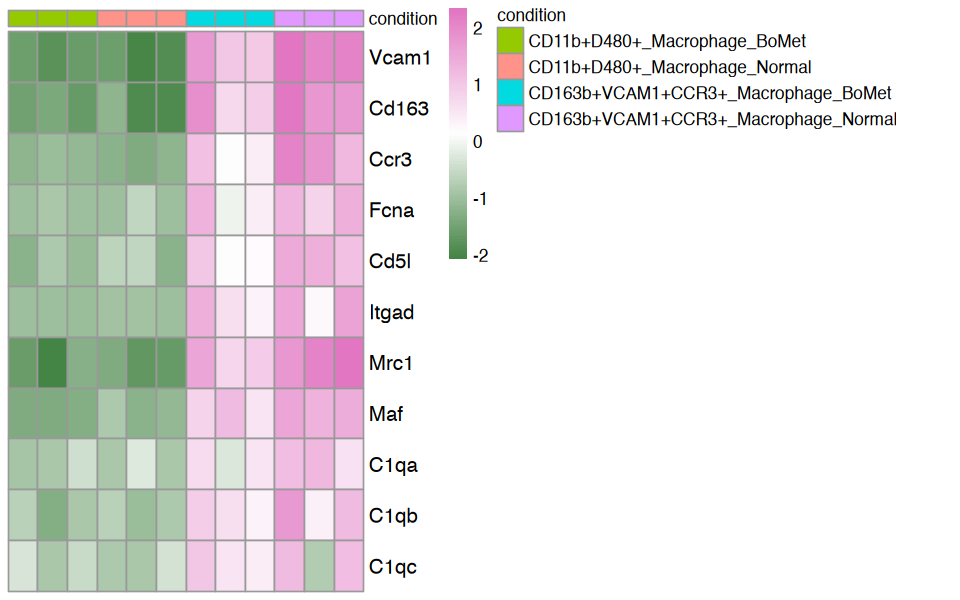

In [11]:
#plot Macrophage_c signature genes
genes1 <- c("Vcam1","Cd163","Ccr3","Fcna","Cd5l",
            "Itgad","Mrc1","Maf","C1qa","C1qb","C1qc")
mat <- assay(vsd)[genes1, ]
mat <- mat - rowMeans(mat)
anno <- as.data.frame(colData(vsd)[c("condition")])

fig_size(5, 8)
p <- pheatmap(mat, annotation_col = anno, 
         cluster_rows=FALSE, 
         show_rownames=TRUE,
         cluster_cols=FALSE,
         show_colnames=FALSE,
         fontsize_col = 12,
         fontsize_row = 12,
         color=colorRampPalette(c("#448444", "white", "#E276C2"))(n = 100))
         #border_color="black")
p

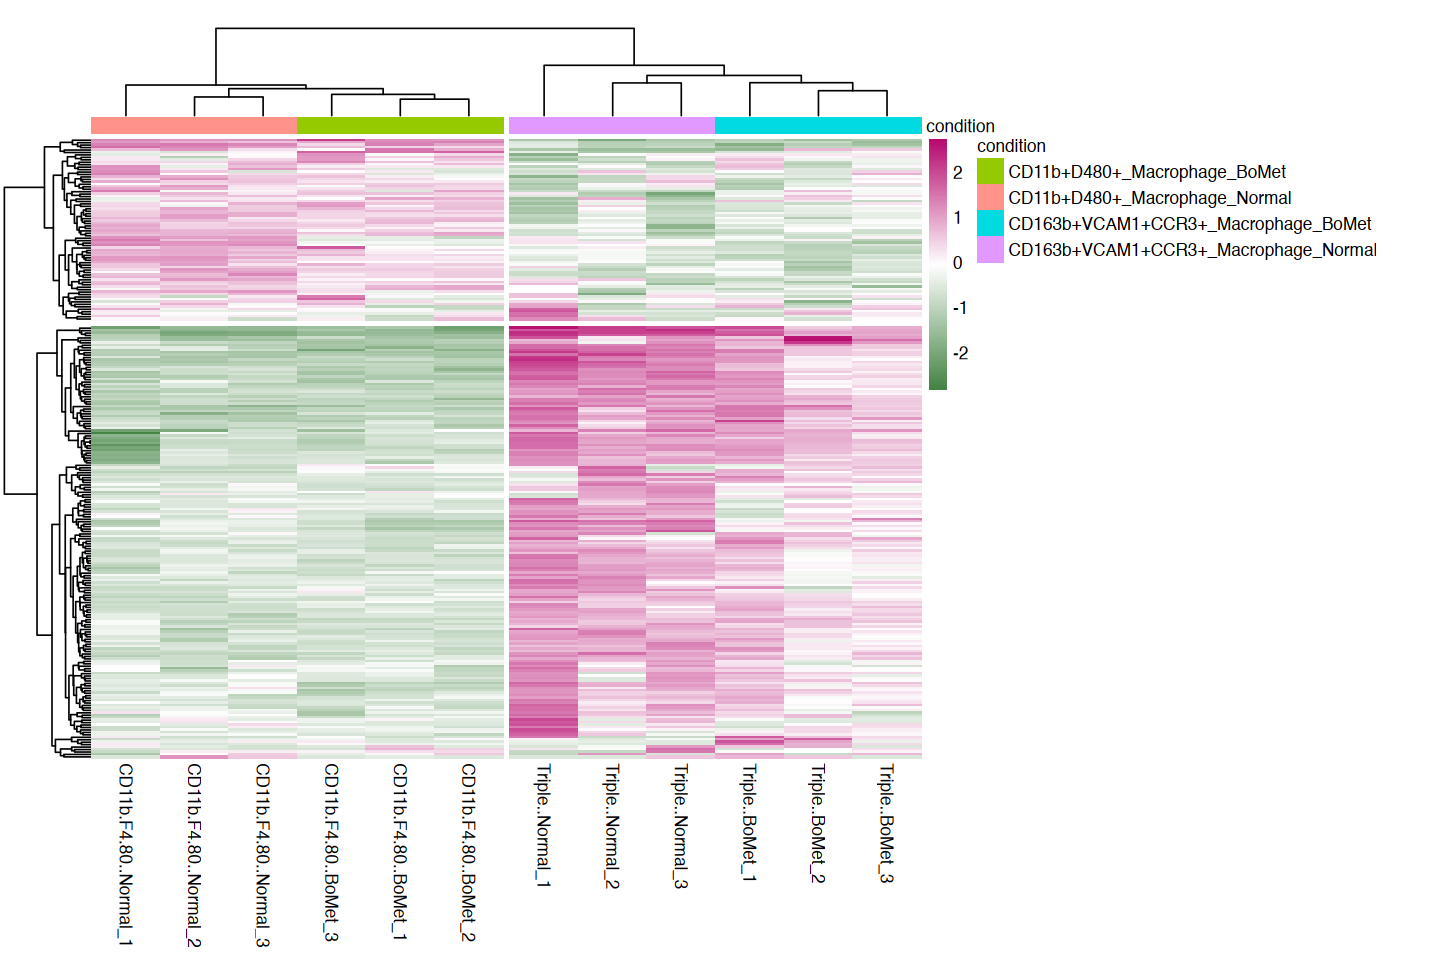

In [8]:
# Variable Genes Heatmap

vsd <- vst(dds, blind = TRUE)
variable_gene_heatmap <- function (vsd.obj, num_genes = 500, annotation, title = "") {
  brewer_palette <- "RdBu"
  # Ramp the color in order to get the scale.
  mr <-colorRampPalette(c("#448444", "white", "#b70b70"))(100)
  # get the stabilized counts from the vsd object
  stabilized_counts <- assay(vsd.obj)
  # calculate the variances by row(gene) to find out which genes are the most variable across the samples.
  row_variances <- rowVars(stabilized_counts)
  # get the top most variable genes
  top_variable_genes <- stabilized_counts[order(row_variances, decreasing=T)[1:num_genes],]
  # subtract out the means from each row, leaving the variances for each gene
  top_variable_genes <- top_variable_genes - rowMeans(top_variable_genes, na.rm=T)
  # replace the ensembl ids with the gene names
  gene_names <- annotation$Gene.name[match(rownames(top_variable_genes), annotation$Gene.stable.ID)]
  rownames(top_variable_genes) <- gene_names
  # reconstruct colData without sizeFactors for heatmap labeling
  coldata <- as.data.frame(vsd.obj@colData)
  coldata$sizeFactor <- NULL
  # draw heatmap using pheatmap
  pheatmap::pheatmap(top_variable_genes, color = mr, annotation_col = coldata, fontsize_col = 10, fontsize_row = 250/num_genes, border_color = NA, main = title,cutree_cols=2, cutree_rows=2)
}

fig_size(8, 12)
variable_gene_heatmap(vsd, num_genes = 250, 
                      annotation = my_colData)

## **Figure 2**

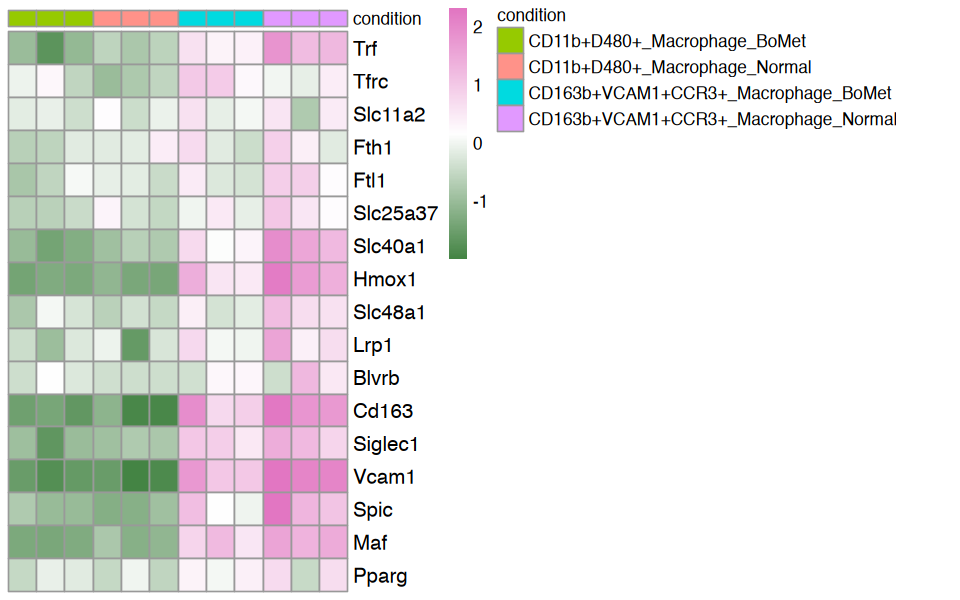

In [12]:
#plot iron metabolism genes
genes2 <- c("Trf","Tfrc","Slc11a2","Fth1","Ftl1","Slc25a37",
            "Slc40a1",
            "Hmox1","Slc48a1","Lrp1","Blvrb",
            "Cd163","Siglec1","Vcam1",
            "Spic","Maf","Pparg")
mat <- assay(vsd)[genes2, ]
mat <- mat - rowMeans(mat)
anno <- as.data.frame(colData(vsd)[c("condition")])

fig_size(5, 8)
pheatmap(mat, annotation_col = anno, 
         cluster_rows=F, 
         show_rownames=TRUE,
         cluster_cols=F,
         show_colnames=FALSE,
         fontsize_col = 12,
         fontsize_row = 12,
         color=colorRampPalette(c("#448444", "white", "#E276C2"))(n = 200))

In [12]:
#Perform DE analysis on "CD163b+VCAM1+CCR3+_Macrophage_BoMet" vs "CD11b+D480+_Macrophage_BoMet"
suppressMessages({
    subset_dds <- dds[, dds$condition %in% c("CD163b+VCAM1+CCR3+_Macrophage_BoMet", 
                                             "CD11b+D480+_Macrophage_BoMet")]
    subset_dds$condition <- droplevels(subset_dds$condition)
    subset_dds <- DESeq(subset_dds)
    res <- results(subset_dds, contrast = c("condition", 
                                            "CD163b+VCAM1+CCR3+_Macrophage_BoMet", 
                                            "CD11b+D480+_Macrophage_BoMet"))
    filtered_res <- res[ rowMeans(counts(dds, normalized = TRUE)) > 10, ]
        })

In [13]:
ranked_genes <- filtered_res$log2FoldChange
names(ranked_genes) <- rownames(filtered_res)
ranked_genes <- sort(ranked_genes, 
                     decreasing = TRUE)

msigdb_genesets <- msigdbr(species = "mouse", 
                           category = "H")
hallmark_gene_sets <- split(x = msigdb_genesets$gene_symbol, 
                            f = msigdb_genesets$gs_name)
fgsea_results <- fgsea(pathways = hallmark_gene_sets, 
                       stats = ranked_genes)
head(fgsea_results[order(fgsea_results$padj), ])

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_HEME_METABOLISM,2.448889e-05,0.001224445,0.57561026,0.5827038,1.7313320,177,"Mboat2, ...."
HALLMARK_KRAS_SIGNALING_DN,3.066777e-02,0.587586294,0.35248786,0.5518288,1.4391554,64,"Tgfb2, G...."
HALLMARK_MYOGENESIS,3.525518e-02,0.587586294,0.32177592,0.5011882,1.3827171,100,"Camk2b, ...."
HALLMARK_ADIPOGENESIS,6.075949e-01,1.000000000,0.05237591,0.3121948,0.9283081,175,"Cavin2, ...."
HALLMARK_ALLOGRAFT_REJECTION,6.916549e-01,1.000000000,0.04669480,0.3044264,0.8954383,160,"Tgfb2, C...."
HALLMARK_ANDROGEN_RESPONSE,6.733129e-01,1.000000000,0.05163560,0.3287352,0.8994479,87,"Homer2, ...."


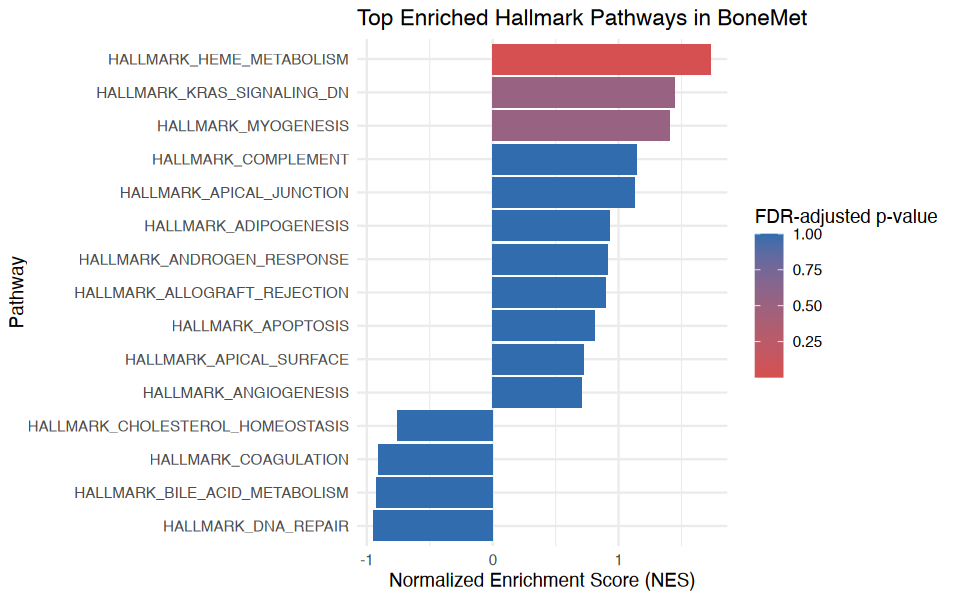

In [9]:
fig_size(5, 8)
top_pathways <- fgsea_results[order(fgsea_results$padj), ][1:15, ]
ggplot(top_pathways, aes(x = reorder(pathway, NES), y = NES)) +
  geom_col(aes(fill = padj)) +  # Color based on pval
  scale_fill_gradient(low = "#D65051", 
                      high = "#306CAE", 
                      name = "FDR-adjusted p-value") +  
  coord_flip() +
  labs(x = "Pathway", 
       y = "Normalized Enrichment Score (NES)", 
       title = "Top Enriched Hallmark Pathways in BoneMet") +
  theme_minimal()

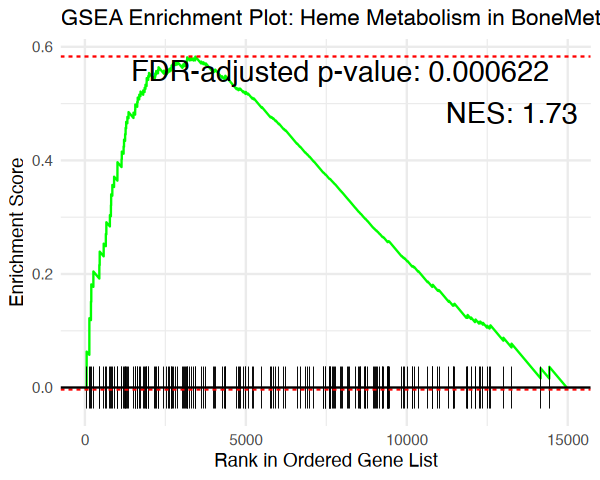

In [10]:
#Perform GSEA analysis on pre-ranked "CD163b+VCAM1+CCR3+_Macrophage_BoneMet" vs "CD11b+D480+_Macrophage_BoneMet" DE genes
nes <- fgsea_results[fgsea_results$pathway == "HALLMARK_HEME_METABOLISM", "NES"]
heme_padj <- fgsea_results[fgsea_results$pathway == "HALLMARK_HEME_METABOLISM", "padj"]
fig_size(4, 5)
plotEnrichment(
  hallmark_gene_sets[["HALLMARK_HEME_METABOLISM"]],
  ranked_genes) +
  labs(title = "GSEA Enrichment Plot: Heme Metabolism in BoneMet") +
  theme_minimal()+
  annotate("text", x = Inf, y = Inf, label = paste("NES:", round(nes, 2)), 
           hjust = 1.1, vjust = 4, size = 6, color = "black") +  # NES annotation
  annotate("text", x = Inf, y = Inf, label = paste("FDR-adjusted p-value:", signif(heme_padj, digits = 3)), 
           hjust = 1.1, vjust = 2, size = 6, color = "black") +  # p-value annotation
  labs(x = "Rank in Ordered Gene List", y = "Enrichment Score") + 
  theme_minimal()

In [11]:
#Perform DE analysis on "CD163b+VCAM1+CCR3+_Macrophage_Normal" vs "CD11b+D480+_Macrophage_Normal"
subset_dds2 <- dds[, dds$condition %in% c("CD163b+VCAM1+CCR3+_Macrophage_Normal", 
                                          "CD11b+D480+_Macrophage_Normal")]
subset_dds2$condition <- droplevels(subset_dds2$condition)
subset_dds2 <- DESeq(subset_dds2)
res2 <- results(subset_dds2, contrast = c("condition", 
                                          "CD163b+VCAM1+CCR3+_Macrophage_Normal", 
                                          "CD11b+D480+_Macrophage_Normal"))
filtered_res2 <- res2[ rowMeans(counts(dds, normalized = TRUE)) > 10, ]

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



In [12]:
#Perform GSEA analysis on pre-ranked "CD163b+VCAM1+CCR3+_Macrophage_Normal" vs "CD11b+D480+_Macrophage_Normal" DE genes
ranked_genes2 <- filtered_res2$log2FoldChange
names(ranked_genes2) <- rownames(filtered_res2)
ranked_genes2 <- sort(ranked_genes2, 
                      decreasing = TRUE)

msigdb_genesets <- msigdbr(species = "mouse", 
                           category = "H")
hallmark_gene_sets <- split(x = msigdb_genesets$gene_symbol, 
                            f = msigdb_genesets$gs_name)
fgsea_results2 <- fgsea(pathways = hallmark_gene_sets, 
                        stats = ranked_genes2)
head(fgsea_results2[order(fgsea_results2$padj), ])

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (4.65% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_HEME_METABOLISM,1.149225e-06,5.746125e-05,0.64355184,0.5387651,1.7960310,178,"Mgst3, A...."
HALLMARK_ANDROGEN_RESPONSE,1.240607e-02,3.101517e-01,0.38073040,0.4751352,1.4378824,88,"Rab4a, G...."
HALLMARK_ADIPOGENESIS,3.401163e-01,1.000000e+00,0.12563992,0.3093666,1.0277093,176,"Mgst3, C...."
HALLMARK_ALLOGRAFT_REJECTION,2.260870e-01,1.000000e+00,0.15740290,0.3279722,1.0765751,159,"Cd4, Cxc...."
HALLMARK_ANGIOGENESIS,7.223199e-01,1.000000e+00,0.05468085,-0.3680446,-0.8181149,21,"S100a4, ...."
HALLMARK_APICAL_JUNCTION,9.791332e-01,1.000000e+00,0.03653149,-0.2498612,-0.7522864,124,"Col17a1,...."


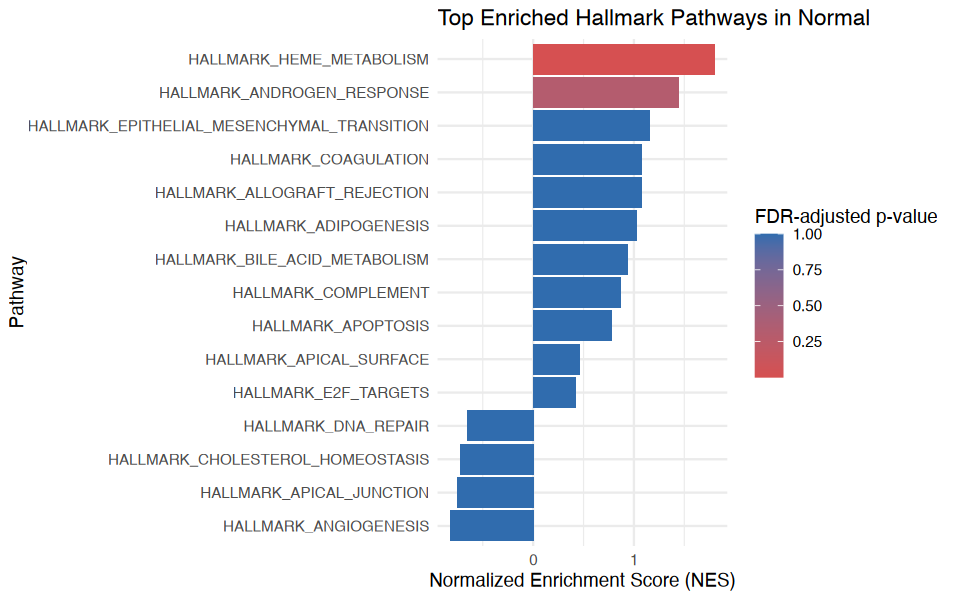

In [13]:
fig_size(5, 8)
top_pathways2 <- fgsea_results2[order(fgsea_results2$padj), ][1:15, ]
ggplot(top_pathways2, aes(x = reorder(pathway, NES), y = NES)) +
  geom_col(aes(fill = padj)) +  # Color based on pval
  scale_fill_gradient(low = "#D65051", high = "#306CAE", name = "FDR-adjusted p-value") +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score (NES)", 
       title = "Top Enriched Hallmark Pathways in Normal") +
  theme_minimal()

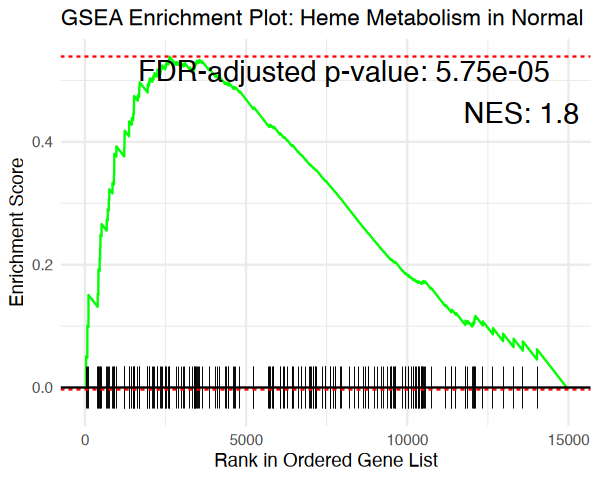

In [14]:
nes <- fgsea_results2[fgsea_results2$pathway == "HALLMARK_HEME_METABOLISM", "NES"]
heme_padj <- fgsea_results2[fgsea_results2$pathway == "HALLMARK_HEME_METABOLISM", "padj"]
fig_size(4, 5)
plotEnrichment(
  hallmark_gene_sets[["HALLMARK_HEME_METABOLISM"]],
  ranked_genes2) +
  labs(title = "GSEA Enrichment Plot: Heme Metabolism in Normal") +
  theme_minimal()+
  annotate("text", x = Inf, y = Inf, 
           label = paste("NES:", round(nes, 2)), 
           hjust = 1.1, vjust = 4, size = 6, color = "black") +  # NES annotation
  annotate("text", x = Inf, y = Inf, 
           label = paste("FDR-adjusted p-value:", signif(heme_padj, digits = 3)), 
           hjust = 1.1, vjust = 2, size = 6, color = "black") +  # p-value annotation
  labs(x = "Rank in Ordered Gene List", y = "Enrichment Score") + 
  theme_minimal()